In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import sklearn.cross_validation as CV

# ANN

In [5]:
from sklearn.metrics import roc_auc_score

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

## Helper functions and classes

In [6]:
def linear_activation(vector, weights, bias):
    return tf.matmul(vector, weights) + bias

In [7]:
class BatchGenerator():
    def __init__(self, X, y, batch_size):
        self.X = X
        self.Y = y
        self.batch_size = batch_size
        self.n_batch = (len(X) // batch_size)
        self.index = 0

    def get_batch(self):
        batch_range = range(self.index, (self.index+1)*self.batch_size)
        if self.index == self.n_batch:
            batch_range = range(self.index, len(self.X))
        self.index += 1

        return self.X[batch_range], self.Y[batch_range]

    def resetIndex(self):
        self.index = 0

### NN layers
As far this is ad-hoc solution for test task layer composing fuctions includes code for regularization

In [8]:
class One2OneLayer(object):
    def __init__(self, input_layer, weight_init=None):
        input_size = input_layer.get_shape()[1].value

        o2o_weights = tf.Variable(tf.random_normal([input_size]))
        o2o_output = input_layer * o2o_weights

        self.output = o2o_output
        self.input = input_layer
        self.output = o2o_output
        self.weights = o2o_weights
    
class DenseLayer():
    def __init__(self, input_layer, layer_size, activation):
        input_size = input_layer.get_shape()[1].value
        
        weights = tf.Variable(tf.random_normal([input_size, layer_size]))
        bias = tf.Variable(tf.random_normal([layer_size]))

        z = linear_activation(input_layer, weights, bias)
        output = activation(z)
        
        self.input = input_layer
        self.bias = bias
        self.output = output
        self.weights = weights
        
class SoftmaxLayer():
    """
        This class describes the outpu layer of NN
        with softmax loss function
    """
    def __init__(self, input_layer, layer_size, y):
        input_size = input_layer.get_shape()[1].value

        weights = tf.Variable(tf.random_normal([input_size, layer_size]))
        bias = tf.Variable(tf.random_normal([layer_size]))

        z = linear_activation(input_layer, weights, bias)
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=z))

        # Evaluate model
        correct_predictions = tf.equal(tf.argmax(z, 1), tf.argmax(y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
        
        self.input = input_layer
        self.bias = bias
        self.output = z
        self.weights = weights
        
        self.cost = cost
        self.y = y


In [9]:
class DeepFeatureSelectionNN():
    def __init__(self, X, Y, layers_dimentions=100, n_layers=5, activation=tf.nn.sigmoid,
                 lambda1=0.001, lambda2=1.0, alpha1=0.001, alpha2=0.0):
        self.X = X
        self.Y = Y
    
        #Calculate shapes
        n_sample, n_feat = X.shape
        n_classes =  Y.shape[1] # len(np.unique(y))
    
        #Init input layers
        self.input_X = tf.placeholder("float32", shape=(None, n_feat), name="input_X")
        self.input_y = tf.placeholder("float32", shape=(None, n_classes), name="input_Y")
        
        #Add one2one, dense and softmax layers
        self.hidden_layers = []
        self.hidden_layers.append(One2OneLayer(self.input_X))
        
        dims = []
        if type(layers_dimentions) != list:
            dims = [layers_dimentions for k in range(n_layers)]
        else:
            dims = layers_dimentions
        
        for layer_size in dims:
            input_hidden = self.hidden_layers[-1].output if self.hidden_layers else self.input_X
            self.hidden_layers.append(DenseLayer(input_hidden, layer_size, activation=activation))
            
        self.output_layer = SoftmaxLayer(self.hidden_layers[-1].output, n_classes, self.input_y)
        self.hidden_layers.append(self.output_layer)
        
        #Collect weights from layers
        w = self.hidden_layers[0].weights
        sqr_frob_norm = [tf.norm(l.weights, 'euclidean') ** 2 for l in self.hidden_layers[1:]]
        l1_norm = [tf.norm(l.weights, 1) for l in self.hidden_layers[1:]]
        
        #Precalculate regularization terms
        regularization1 = lambda1*((1.0-lambda2) * 0.5 * tf.norm(w) ** 2 + lambda2 * tf.norm(w, 1))
        regularization2 = alpha1*((1.0-alpha2) * 0.5 * tf.add_n(sqr_frob_norm) +  lambda1 * tf.add_n(l1_norm))
        
        #Calculate cost function
        self.cost = self.output_layer.cost + regularization1 + regularization2
        
    def train(self,lerning_rate=0.01, epochs=1000, batch_size=100, 
              verbose=True, print_step=100, random_state=441):
        X_train, X_test, Y_train, Y_test = CV.train_test_split(self.X, 
                                                               self.Y, 
                                                               random_state=random_state)
        
        GDoptimizer = tf.train.AdamOptimizer(lerning_rate)\
                              .minimize(self.cost)
        
        self.accuracy = self.output_layer.accuracy
        #self.y = self.softmax_layer.y
        
        s = tf.Session()
        self.s = s
        s.run(tf.global_variables_initializer())
        
        #batch_generator = BatchGenerator(X_train, Y_train, batch_size)
        #n_batch = batch_generator.n_batch
        
        self.losses, self.train_accs, self.test_accs = [], [], []
        
        for i in range(epochs):
            #batch_generator.resetIndex()
            #for j in range(n_batch + 1):
                #x_batch, y_batch = batch_generator.get_batch()
                
            idx = np.random.randint(X_train.shape[0], size=batch_size)
            x_batch, y_batch = X_train[idx,:], Y_train[idx,:]
                
            s.run(GDoptimizer, feed_dict={self.input_X : x_batch, self.input_y: y_batch})

            self.train_accs.append(s.run(self.output_layer.accuracy,
                                         feed_dict={self.input_X: X_train, self.input_y: Y_train}))
            self.test_accs.append(s.run(self.output_layer.accuracy,
                                           feed_dict={self.input_X: X_test, self.input_y: Y_test}))
            self.losses.append(s.run(self.cost,
                                        feed_dict={self.input_X: x_batch, self.input_y: y_batch}))

            if verbose and i % print_step == 0:
                print('epoch {}: loss = {}'.format(i, self.losses[-1]))
                print("Train accuracy:", self.train_accs[-1])
                print("Test accuracy:", self.test_accs[-1])

                print("train auc:", roc_auc_score(Y_train, s.run(self.output_layer.output, 
                                                                 {self.input_X: X_train})))
                print("test auc:", roc_auc_score(Y_test, s.run(self.output_layer.output, 
                                                               {self.input_X: X_test})))
        
        self.selected_ws = s.run(self.hidden_layers[0].weights)
        if verbose:
            print("Final train accuracy:", self.train_accs[-1])
            print("Final test accuracy:", self.test_accs[-1])

Using TensorFlow backend.


(50000, 28, 28) (50000,)


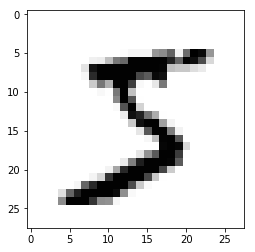

In [10]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [11]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
Y = np.hstack([y_train, y_val, y_test])
Y.shape
Y_encoded = enc.fit_transform(np.asmatrix(Y).T).todense()
y_train_coded, y_val_coded, y_test_coded = Y_encoded[:50000,:], Y_encoded[50000:60000,:], Y_encoded[60000:,:]
y_train_coded.shape, y_val_coded.shape, y_test_coded.shape
X_train_f = X_train.reshape([X_train.shape[0], 28*28])
X_val_f = X_val.reshape([X_val.shape[0], 28*28])
X_test_f = X_test.reshape([X_test.shape[0], 28*28])
X_train_f.shape, X_val_f.shape, X_test_f.shape

((50000, 784), (10000, 784), (10000, 784))

In [12]:
X_ = np.vstack([X_train_f, X_val_f, X_test_f])
Y_ = Y_encoded

In [13]:
%%time
nn = DeepFeatureSelectionNN(X_, Y_, layers_dimentions = [784, 392], activation=tf.nn.relu)
nn.train(0.002, 2000, 100)

epoch 0: loss = 4901.7109375
Train accuracy: 0.08135238
Test accuracy: 0.07971428
train auc: 0.5175752470012721
test auc: 0.5164191747965445
epoch 100: loss = 604.2279052734375
Train accuracy: 0.82321906
Test accuracy: 0.818
train auc: 0.9474735918000323
test auc: 0.9477616152277186
epoch 200: loss = 511.8580322265625
Train accuracy: 0.8653143
Test accuracy: 0.8602286
train auc: 0.9592844929430931
test auc: 0.9587511485840639
epoch 300: loss = 529.4495849609375
Train accuracy: 0.89657146
Test accuracy: 0.8862857
train auc: 0.9659371681866104
test auc: 0.9643075289575409
epoch 400: loss = 449.665771484375
Train accuracy: 0.9081143
Test accuracy: 0.8967429
train auc: 0.9705304591576225
test auc: 0.9685528394355842
epoch 500: loss = 407.5274353027344
Train accuracy: 0.91958094
Test accuracy: 0.9048
train auc: 0.9736629951319132
test auc: 0.971128708032218
epoch 600: loss = 401.86773681640625
Train accuracy: 0.9283619
Test accuracy: 0.9110857
train auc: 0.9752064576528982
test auc: 0.97275

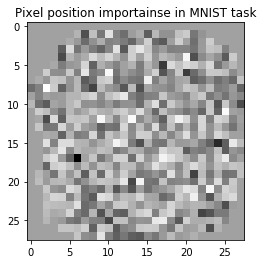

In [22]:
ww = nn.selected_ws.reshape((28,28))

plt.title("Pixel position importainse in MNIST task")
plt.imshow(ww, cmap="Greys");